# DATA LOADING

In [1]:
import pandas as pd
import numpy as np
from random_forest_scratch import RandomForestScratch
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

DATA_PATH = "earthquake_1995-2023.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
alert_mapping = {
    'none': 0,
    'green': 1,
    'yellow': 2,
    'orange': 3,
    'red': 4
}

df['alert_encoded'] = df['alert'].fillna('none').map(alert_mapping)
df_clean = df.select_dtypes(include=[np.number])

X = df_clean.drop('tsunami', axis=1).values
y = df_clean['tsunami'].values

print(f"Data loaded. Shape of X: {X.shape}, Shape of y: {y.shape}")

Data loaded. Shape of X: (1000, 11), Shape of y: (1000,)


# RANDOM FOREST FROM SCRATCH HYPERPARAMETERS


In [2]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

param_grid = {
    'n_trees': [10, 20],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_f1 = 0
best_std = 0
best_params = {}
grid_results_storage = []

for params in param_combinations:
    inner_kf = KFold(n_splits=3, shuffle=True, random_state=5)
    fold_f1_scores = []

    for t_idx, v_idx in inner_kf.split(X):
        clf_temp = RandomForestScratch(**params)
        clf_temp.fit(X[t_idx], y[t_idx])
        preds = clf_temp.predict(X[v_idx])

        score = f1_score(y[v_idx], preds, average='binary')
        fold_f1_scores.append(score)

    mean_f1 = np.mean(fold_f1_scores)
    std_f1 = np.std(fold_f1_scores)

    result_entry = params.copy()
    result_entry['Mean_F1'] = mean_f1
    result_entry['Std_Dev'] = std_f1
    grid_results_storage.append(result_entry)

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_std = std_f1
        best_params = params
    elif mean_f1 == best_f1:
        if std_f1 < best_std:
            best_std = std_f1
            best_params = params

grid_results_df = pd.DataFrame(grid_results_storage).sort_values(by='Mean_F1', ascending=False)

print("\n" + "="*85)
print(f"{'n_trees':<8} | {'depth':<6} | {'min_split':<10} | {'Mean F1':<12} | {'Std Dev':<10}")
print("-" * 85)

for _, row in grid_results_df.iterrows():
    print(f"{int(row['n_trees']):<8} | {int(row['max_depth']):<6} | {int(row['min_samples_split']):<10} | "
          f"{row['Mean_F1']:.4f}       | +/- {row['Std_Dev']:.4f}")

print("="*85)
print(f"Best Params: {best_params} (F1 Score: {best_f1:.4f})\n")


n_trees  | depth  | min_split  | Mean F1      | Std Dev   
-------------------------------------------------------------------------------------
20       | 5      | 2          | 0.9019       | +/- 0.0103
20       | 5      | 5          | 0.9000       | +/- 0.0138
10       | 5      | 2          | 0.8992       | +/- 0.0246
10       | 5      | 5          | 0.8967       | +/- 0.0176
10       | 10     | 5          | 0.8925       | +/- 0.0073
20       | 20     | 5          | 0.8907       | +/- 0.0118
10       | 10     | 2          | 0.8866       | +/- 0.0119
20       | 10     | 5          | 0.8855       | +/- 0.0088
10       | 20     | 2          | 0.8846       | +/- 0.0101
20       | 20     | 2          | 0.8843       | +/- 0.0140
20       | 10     | 2          | 0.8838       | +/- 0.0042
10       | 20     | 5          | 0.8837       | +/- 0.0168
Best Params: {'n_trees': 20, 'max_depth': 5, 'min_samples_split': 2} (F1 Score: 0.9019)



# RANDOM FOREST FROM SCRATCH RUN WITH BEST HYPERPARAMETERS


In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics_storage = {
    'Accuracy': [],
    'Precision': [],
    'Recall (Sensitivity)': [],
    'F-Measure': [],
    'AUC (ROC)': [],
    'AUPRC': []
}

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = RandomForestScratch(
        n_trees=best_params['n_trees'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split']
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_prob(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if len(np.unique(y_test)) > 1:
        auc = roc_auc_score(y_test, y_prob)
        auprc = average_precision_score(y_test, y_prob)
    else:
        auc = 0.0
        auprc = 0.0

    metrics_storage['Accuracy'].append(acc)
    metrics_storage['Precision'].append(prec)
    metrics_storage['Recall (Sensitivity)'].append(rec)
    metrics_storage['F-Measure'].append(f1)
    metrics_storage['AUC (ROC)'].append(auc)
    metrics_storage['AUPRC'].append(auprc)

    print(f"Fold {fold + 1}: Acc={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

Fold 1: Acc=0.915 | F1=0.878 | AUC=0.961
Fold 2: Acc=0.940 | F1=0.926 | AUC=0.968
Fold 3: Acc=0.925 | F1=0.899 | AUC=0.973
Fold 4: Acc=0.945 | F1=0.912 | AUC=0.984
Fold 5: Acc=0.915 | F1=0.864 | AUC=0.951


# Statystical analysis and summary table for the scratch implementation

In [8]:
print("\n" + "=" * 60)
print(f"{'Metric':<25} | {'Mean':<10} | {'Std Dev':<10}")
print("=" * 60)

results_summary = {}

for metric, values in metrics_storage.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    results_summary[metric] = (mean_val, std_val)

    print(f"{metric:<25} | {mean_val:.4f}     | +/- {std_val:.4f}")

print("=" * 60)


Metric                    | Mean       | Std Dev   
Accuracy                  | 0.9280     | +/- 0.0125
Precision                 | 0.8366     | +/- 0.0380
Recall (Sensitivity)      | 0.9656     | +/- 0.0247
F-Measure                 | 0.8958     | +/- 0.0225
AUC (ROC)                 | 0.9675     | +/- 0.0108
AUPRC                     | 0.8923     | +/- 0.0430


# LIBRARY IMPLEMENTATION (Scikit-Learn) & COMPARISON

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

rf_library = RandomForestClassifier(random_state=5)
grid_search = GridSearchCV(estimator=rf_library, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

best_rf_library = grid_search.best_estimator_
print(f"Best Library Params: {grid_search.best_params_}")

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

library_results = cross_validate(best_rf_library, X, y, cv=kf, scoring=scoring_metrics)

print("\n" + "=" * 60)
print(f"{'Metric (Library)':<25} | {'Mean':<10} | {'Std Dev':<10}")
print("=" * 60)

print(
    f"{'Accuracy':<25} | {library_results['test_accuracy'].mean():.4f}     | +/- {library_results['test_accuracy'].std():.4f}")
print(
    f"{'Precision':<25} | {library_results['test_precision'].mean():.4f}     | +/- {library_results['test_precision'].std():.4f}")
print(
    f"{'Recall':<25} | {library_results['test_recall'].mean():.4f}     | +/- {library_results['test_recall'].std():.4f}")
print(f"{'F1-Measure':<25} | {library_results['test_f1'].mean():.4f}     | +/- {library_results['test_f1'].std():.4f}")
print(
    f"{'AUC (ROC)':<25} | {library_results['test_roc_auc'].mean():.4f}     | +/- {library_results['test_roc_auc'].std():.4f}")
print("=" * 60)

Best Library Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 20}

Metric (Library)          | Mean       | Std Dev   
Accuracy                  | 0.8920     | +/- 0.0236
Precision                 | 0.7710     | +/- 0.0531
Recall                    | 0.9469     | +/- 0.0176
F1-Measure                | 0.8492     | +/- 0.0379
AUC (ROC)                 | 0.9594     | +/- 0.0138


# INTERPRETABILITY (SHAP)

  0%|          | 0/200 [00:00<?, ?it/s]

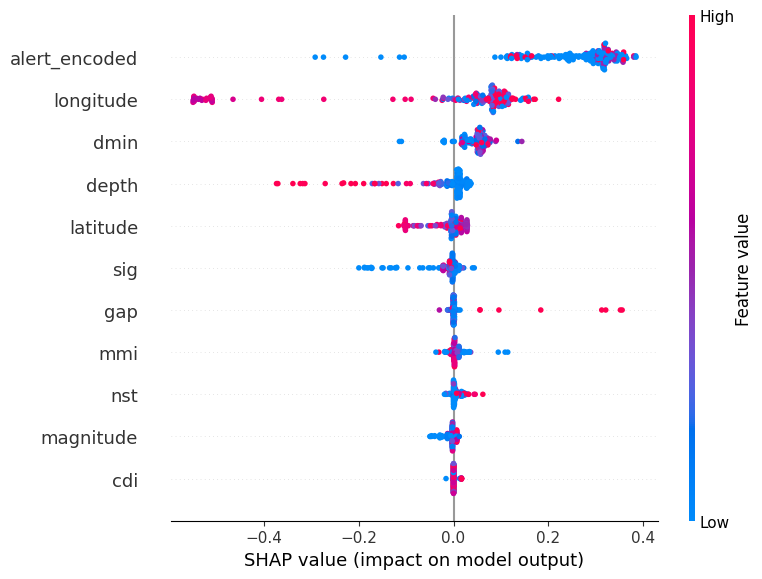

In [6]:
import shap

background_data = shap.kmeans(X, 50)
explainer = shap.KernelExplainer(clf.predict_prob, background_data)

X_explain = X[:200]
shap_values = explainer.shap_values(X_explain)

feature_names = df_clean.drop('tsunami', axis=1).columns.tolist()

shap.summary_plot(shap_values, X_explain, feature_names=feature_names)

  0%|          | 0/200 [00:00<?, ?it/s]

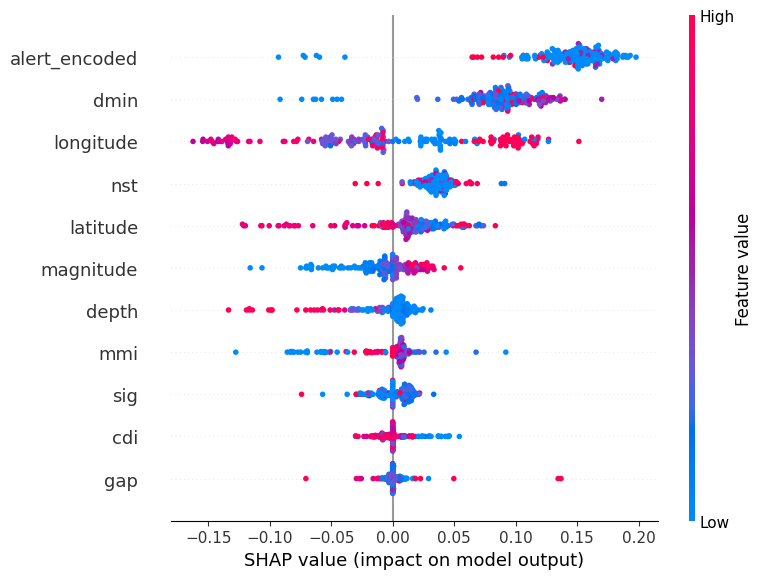

In [7]:
explainer_lib = shap.KernelExplainer(lambda x: best_rf_library.predict_proba(x)[:, 1], background_data)

shap_values_lib = explainer_lib.shap_values(X_explain)

shap.summary_plot(shap_values_lib, X_explain, feature_names=feature_names)